## Create vehicles gdf for each optmization + make stats + visualise it all

### Libraries Import 

In [19]:
import time
import math 
import pandas as pd
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import LineString, MultiLineString
from shapely.geometry import Point, Polygon
import geopandas as gpd
import matplotlib.lines as mlines
from matplotlib.colors import LinearSegmentedColormap  # Ensure this line is included
import mapclassify
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator



#### Add joined CBS and special vehicles lists

In [20]:
def get_joined_cbs_gdf(vehicles_gdf, cbs_gdf, vehicle_crs_col='crs28922_list', cbs_crs_col='crs28992'):
    """
    Loads data and returns joined CBS GeoDataFrame based on CRS cell matches.

    Parameters:
    - vehicles_csv_path : path to vehicles summary CSV
    - cbs_shp_path      : path to CBS shapefile
    - vehicle_crs_col   : column name in vehicles_gdf holding CRS-list
    - cbs_crs_col       : column name in cbs_gdf holding the CRS code

    Returns:
    - GeoDataFrame of filtered CBS cells
    """
    def extract_unique_crs_codes(df, column):
        unique_cells = set()
        for val in df[column]:
            if isinstance(val, list):
                unique_cells.update(val)
            else:
                inner = val.strip("[]")
                parts = inner.split("', '")
                parts = [p.strip(" '\"") for p in parts if p.strip(" '\"")]
                unique_cells.update(parts)
        return list(unique_cells)

  
    # Extract codes and filter
    codes = extract_unique_crs_codes(vehicles_gdf, column=vehicle_crs_col)
    return cbs_gdf[cbs_gdf[cbs_crs_col].isin(codes)].copy()


#### Add Statistics City etc. (Module 3)

In [21]:
def generate_summary_statistics(cbs_gdf, area_name='Amsterdam'):
    """
    Calculates summary statistics from the CBS GeoDataFrame, excluding specified columns,
    and formats the results into a summary DataFrame.

    Parameters:
        cbs_gdf (gpd.GeoDataFrame): GeoDataFrame containing CBS data.

    Returns:
        pd.DataFrame: A DataFrame containing the summary statistics.
    """
    # Calculate the sum for numeric columns excluding 'G_woz_woni' and 'geometry'
    sum_values = cbs_gdf.drop(columns=['geometry', 'G_woz_woni']).sum()
    
    # Calculate the average for 'G_woz_woni'
    average_woz_woni = cbs_gdf['G_woz_woni'].mean()
    
    # Round the sums and average to zero decimal places
    rounded_sum_values = sum_values.round(0)
    rounded_average_woz_woni = round(average_woz_woni, 0)
    
    # Create the summary row DataFrame
    summary_row_ams = pd.DataFrame({
        'Area': [area_name],
        'A_inhab': [rounded_sum_values.get('A_inhab', 0)],
        'A_0_15': [rounded_sum_values.get('A_0_15', 0)],
        'A_15_25': [rounded_sum_values.get('A_15_25', 0)],
        'A_25_45': [rounded_sum_values.get('A_25_45', 0)],
        'A_45_65': [rounded_sum_values.get('A_45_65', 0)],
        'A_65+': [rounded_sum_values.get('A_65+', 0)],
        'G_woz_woni': [rounded_average_woz_woni],
        'A_nederlan': [rounded_sum_values.get('A_nederlan', 0)],
        'A_west_mig': [rounded_sum_values.get('A_west_mig', 0)],
        'A_n_west_m': [rounded_sum_values.get('A_n_west_m', 0)],
    })

    summary_row_ams['A_inhab'] = summary_row_ams['A_inhab'].astype(int)
    summary_row_ams['G_woz_woni'] = summary_row_ams['G_woz_woni'].astype(int)

    return summary_row_ams

In [22]:
def concatenate_dataframes(dfs, ignore_index=True):
    """
    Concatenates a list of DataFrames into a single DataFrame.

    Parameters:
        dfs (list of pd.DataFrame): List of DataFrames to concatenate.
        ignore_index (bool): Whether to ignore the index and reset it in the resulting DataFrame.

    Returns:
        pd.DataFrame: A single DataFrame resulting from the concatenation of the input DataFrames.
    """
    # Concatenate the DataFrames
    merged_df = pd.concat(dfs, ignore_index=ignore_index)
    
    return merged_df


In [23]:
def calculate_and_compare_sums(cbs_gdf, sensed_gdf):
    """
    Calculates and compares the sums of columns for two GeoDataFrames, and computes the percentage
    of the sensed values relative to the city's total values.

    Parameters:
        cbs_gdf (gpd.GeoDataFrame): GeoDataFrame containing the full city's data.
        sensed_gdf (gpd.GeoDataFrame): GeoDataFrame containing the sensed data.

    Returns:
        pd.DataFrame: A DataFrame containing the sums for both datasets and the percentage of sensed values.
    """
    # Calculate the sum of all columns except 'G_woz_woni', 'geometry', 'index_right', and 'Lijn_Numbe' for the city-wide data
    cbs_sums = cbs_gdf.drop(columns=['crs28992', 'G_woz_woni', 'geometry', 'age_sum', 'migration_' ]).sum()
    
    # Extract values from the Series
    values_t = cbs_sums.values

    # Calculate the sum of all columns except 'G_woz_woni', 'geometry', 'index_right', and 'Lijn_Numbe' for the sensed data
    sensed_sums = sensed_gdf.drop(columns=['crs28992', 'G_woz_woni', 'geometry', 'age_sum', 'migration_']).sum() 				
    
    # Extract values from the Series
    values_s = sensed_sums.values

    # Extract keys (index) from the Series
    keys = sensed_sums.index

    # Create a new DataFrame
    data = {
        'Sociodemo': keys,
        'Sums_sensed': values_s,
        'Sums_total': values_t
    }

    sums = pd.DataFrame(data)
    
    # Calculate the percentage of sensed values relative to the city's total values
    sums['Sensed_%'] = ((sums['Sums_sensed'] / sums['Sums_total']) * 100).round(2)
    # Calculate exclusion
    sums['Excluded!'] = (sums['Sums_total'] - sums['Sums_sensed']).round(0)


    # Convert sums to integer values for cleaner display
    sums['Sums_sensed'] = sums['Sums_sensed'].astype(int)
    sums['Sums_total'] = sums['Sums_total'].astype(int)
    sums['Sensed_%'] = sums['Sensed_%'].astype(float)
    sums['Excluded!'] = sums['Excluded!'].astype(int)
    
    return sums

In [24]:
def normalize_statistics(merged_df):
    """
    Normalizes the columns in the merged_statistics DataFrame based on 'A_inhab'.
    Drops 'A_woning' and 'A_inhab', and rounds the results to two decimal places. Get percentages!
    
    Parameters:
        merged_statistics (pd.DataFrame): The DataFrame containing the statistics to normalize.

    Returns:
        pd.DataFrame: A DataFrame with normalized statistics.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    average_stats = merged_df.copy()


    # Identify columns to normalize
    columns_to_normalize = average_stats.columns.difference(['Area', 'G_woz_woni', 'A_inhab'])

    # Normalize the identified columns
    average_stats[columns_to_normalize] = average_stats[columns_to_normalize].div(average_stats['A_inhab'], axis=0)

    # Drop the 'A_inhab' column
    average_stats = average_stats.drop(columns=['A_inhab'])

    # Round to two decimal places
    average_stats = average_stats.round(4)

    return average_stats

### Data Visualization

In [25]:
def plot_stacked_sums(df, buffer_distance):


    # change names in Sociodemo to Total Pop, Age < 15, Age 15 - 25, Age 25 - 45, Age 45 - 65, Mig. Dutch, Mig. Western, Mig. Non-Western
    df['Sociodemo'] = df['Sociodemo'].replace({
    'A_inhab': 'Total Pop',
    'A_0_15': 'Age < 15',
    'A_15_25': 'Age 15 - 25',
    'A_25_45': 'Age 25 - 45',
    'A_45_65': 'Age 45 - 65',
    'A_65+': 'Age > 65',
    'A_nederlan': 'Mig. Dutch',
    'A_west_mig': 'Mig. Western',
    'A_n_west_m': 'Mig. Non-Western'
        })


    plt.style.use('default')  # normal theme
    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.6
    idx = range(len(df))

    # horizontal grid: major and extra minor lines
    ax.yaxis.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))  # 5 minor intervals
    ax.yaxis.grid(True, which='minor', linestyle=':', linewidth=0.3, alpha=0.5)

    # Stacked bars
    ax.bar(idx,
           df['Sums_sensed'],
           bar_width,
           label='Pop Sensed',
           color='#85b66f')
    ax.bar(idx,
           df['Sums_total'] - df['Sums_sensed'],
           bar_width,
           bottom=df['Sums_sensed'],
           label='Pop Unsensed',
           color='#ffa3c4')

    # Annotate Sensed_% at bottom
    for i, pct in enumerate(df['Sensed_%']):
        ax.text(i, 0, f"{pct:.1f}%",
                ha='center', va='bottom', fontweight='normal')

    # styling
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(axis='both', which='both', length=0)

    # labels
    ax.set_xticks(idx)
    ax.set_xticklabels(df['Sociodemo'], rotation=45,  fontsize=8.5,ha='right', fontweight='bold')
    ax.set_xlabel('Population Groups', fontweight='bold')
    ax.set_ylabel('Inhabitants', fontweight='bold')
    ax.legend(loc='upper right')
    plt.title(f'Public transport sensing {buffer_distance}m buffer', fontweight='bold')
    plt.tight_layout()
    plt.savefig('stacked_sums_plot.png', bbox_inches='tight')
    plt.show()


In [76]:
def plot_transport_and_population(lines, cbs_gdf, sensed_gdf, ams_gdf, buffer_distance, transport_type=None, lijn=None):
    """
    Plots public transport data, CBS population data, and sensed population with a buffer on a map.
    
    Parameters:
        lines (gpd.GeoDataFrame): GeoDataFrame containing the buffered transport data.
        cbs_gdf (gpd.GeoDataFrame): GeoDataFrame containing the CBS data.
        sensed_gdf (gpd.GeoDataFrame): GeoDataFrame containing the sensed data.
        ams_gdf (gpd.GeoDataFrame): GeoDataFrame containing the boundary of the area to plot.
        buffer_distance (float): Distance used for buffering the transport data.
    """

    # ams_gdf = gpd.read_file("data/gemeente_T.shp")
    # ams_gdf.crs = "EPSG:28992"
    ams_gdf = ams_gdf.to_crs("EPSG:28992")
 
    # Filter by transport type if provided
    if transport_type is not None:
        if isinstance(transport_type, list):
            lines = lines[lines["route_type"].isin(transport_type)]
        elif isinstance(transport_type, str):
            lines = lines[lines["route_type"] == transport_type]
        else:
            raise ValueError("transport_type must be a str or list of str")
    
    # Filter by line numbers if provided
    if lijn is not None:
        if isinstance(lijn, list):
            lines = lines[lines["route_id"].isin(lijn)]
        elif isinstance(lijn, int):
            lines = lines[lines["route_id"] == lijn]
        else:
            raise ValueError("lijn must be an int or list of int")

    # Change projection
    lines = lines.to_crs(ams_gdf.crs)
    cbs_gdf = cbs_gdf.to_crs(ams_gdf.crs)
    sensed_gdf = sensed_gdf.to_crs(ams_gdf.crs)
    
    # Set up the plot with a dark background
    plt.style.use('default')

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(15, 10))
    
    
    # Plot the boundary
    ams_gdf.boundary.plot(ax=ax, linewidth=0.5, edgecolor='black')

    
    # Plot the CBS population
    cbs_gdf.plot(ax=ax, markersize=5, color='#e15989', edgecolor='white', linewidth=0.35)
    
    # Plot the sensed population
    sensed_gdf.plot(ax=ax, markersize=5, color='#85b66f', edgecolor='white', linewidth=0.35)

    # Plot the buffered trams on top
    lines.plot(ax=ax, color='black', markersize=0.1, alpha=1)   # Adjust points as needed markersize=0.15 was before
 
    
    # Add title and labels
    ax.set_title(f'Public Transport Sensing {buffer_distance}m Buffer', fontweight='bold', fontsize=12)
    
    # Remove X and Y axes
    ax.set_axis_off()
    
    # Create custom legend handles
    line_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=5, label='Vehicles')
    red_square = mlines.Line2D([], [], color='#e15989', marker='s', markersize=5, linestyle='None', label='Pop Cells')
    green_square = mlines.Line2D([], [], color='#85b66f', marker='s', markersize=5, linestyle='None', label='Sensed Pop Cells')

    
    # Add legend
    ax.legend(handles=[line_handle, red_square, green_square], loc='upper right')

    # Show plot

    plt.show()
    
    # Save plot as PNG
    #plt.savefig('transport_population_plot.png', bbox_inches='tight')
    #plt.close(fig)


In [77]:
def plot_comparison_difference(average_stats):
    """
    Plots the absolute difference in percentage points between Amsterdam and Sensed Area.
    """
    # prepare
    df = average_stats.drop(columns=['G_woz_woni'], errors='ignore')
    df_melted = df.melt(id_vars='Area', var_name='Metric', value_name='Value')
    df_pivot = df_melted.pivot_table(index='Metric', columns='Area', values='Value')

    # compute percentage‐point difference (pp)
    df_pivot['Difference (pp)'] = (
        df_pivot['Sensed Area'] - df_pivot['Amsterdam']
    ).round(4) * 100

    df_result = df_pivot.reset_index()

    # reorder so 'A_n_west_m' is last
    order = [m for m in df_result['Metric'] if m != 'A_n_west_m'] + ['A_n_west_m']
    df_result['Metric'] = pd.Categorical(df_result['Metric'], categories=order, ordered=True)
    df_result = df_result.sort_values('Metric')

    # custom labels
    x_labels = [
        'Age <15', 'Age 15-25', 'Age 25-45',
        'Age 45-65', 'Age >65',
        'Mig. Dutch', 'Mig. Western', 'Mig. Non‑Western'
    ]

    # plot
    plt.figure(figsize=(14, 6))
    ax = plt.gca()

    ax.axhline(0, color='#ffa3c4', linestyle='--', linewidth=3, zorder=1)
    ax.scatter(
        df_result['Metric'],
        df_result['Difference (pp)'],
        color='#85b66f',
        s=150,
        marker='o',
        label='Pop Sensed',
        zorder=2
    )

    ax.set_xlabel('Population Groups', fontweight='bold')
    ax.set_ylabel('Difference (pp)', fontweight='bold')
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=45, fontsize=8.5, ha='right', fontweight='bold')

    ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.legend()
    ax.text(len(x_labels) - 1, 0, 'City Average', fontsize=10, ha='center', va='bottom', fontweight='bold')

    plt.title('Difference in Percentage Points: Sensed Area vs Amsterdam', fontweight='bold')
    plt.tight_layout()
    plt.show()

In [78]:
def plot_pie_charts(average_stats, filename=None):
    """
    Plots two sets of pie charts for different metrics: one for age groups and one for ethnic composition.
    Top row: age groups. Bottom row: ethnic composition.
    """
    df = average_stats

    # Extract data for Amsterdam and Sensed Area
    amsterdam_data = df[df['Area'] == 'Amsterdam']
    sensed_area_data = df[df['Area'] == 'Sensed Area']

    # Data columns
    age_columns = ['A_0_15', 'A_15_25', 'A_25_45', 'A_45_65', 'A_65+']
    ethnic_columns = ['A_nederlan', 'A_west_mig', 'A_n_west_m']

    # Display labels
    age_labels = ['Age <15', 'Age 15-25', 'Age 25-45', 'Age 45-65', 'Age >65']
    ethnic_labels = ['Mig. Dutch', 'Mig. Western', 'Mig. Non‑Western']

    # Color schemes (70% opacity)
    ams_age_colors = ['#ffa3c4B3', '#ff85b1B3', '#ff679fB3', '#ff4a8dB3', '#ff2c7bB3']
    ams_eth_colors = ['#ffa3c4B3', '#ff85b1B3', '#ff679fB3']
    sa_age_colors = ['#85b66fB3', '#73a362B3', '#619055B3', '#4f7d47B3', '#3c6a3aB3']
    sa_eth_colors = ['#85b66fB3', '#73a362B3', '#619055B3']

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Amsterdam - Age
    axs[0, 0].pie(
        amsterdam_data[age_columns].values[0],
        labels=age_labels,
        autopct='%1.1f%%',
        colors=ams_age_colors
    )
    axs[0, 0].set_title('Amsterdam - Age Groups', fontweight='bold')

    # Sensed Area - Age
    axs[0, 1].pie(
        sensed_area_data[age_columns].values[0],
        labels=age_labels,
        autopct='%1.1f%%',
        colors=sa_age_colors
    )
    axs[0, 1].set_title('Sensed Area - Age Groups', fontweight='bold')

    # Amsterdam - Ethnic
    axs[1, 0].pie(
        amsterdam_data[ethnic_columns].values[0],
        labels=ethnic_labels,
        autopct='%1.1f%%',
        colors=ams_eth_colors
    )
    axs[1, 0].set_title('Amsterdam - Migration Groups', fontweight='bold')

    # Sensed Area - Ethnic
    axs[1, 1].pie(
        sensed_area_data[ethnic_columns].values[0],
        labels=ethnic_labels,
        autopct='%1.1f%%',
        colors=sa_eth_colors
    )
    axs[1, 1].set_title('Sensed Area - Migration Groups', fontweight='bold')

    #plt.tight_layout()
    #if filename:
    #plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


## Master Function Analysis


- transport_filepath: "data/public_transport.gpkg"
- cbs_filepath: "cbs_full.shp"
- buffer_distance: 50


In [79]:

def master_function_analysis(transport_filepath, cbs_filepath, buffer_distance, line_number=None, transport_type=None, crs='EPSG:28992'):
    """
    Master function to handle the entire process from reading data to generating comparison statistics.

    """
    gpd_vehicles = gpd.read_file(transport_filepath)
    cbs_gdf = gpd.read_file(cbs_filepath)
    
    # Step 4: Perform spatial join
    joined_gdf = get_joined_cbs_gdf(gpd_vehicles, cbs_gdf)
    
    # Step 5: Generate summary statistics
    stats_ams = generate_summary_statistics(cbs_gdf)
    stats_sensed = generate_summary_statistics(joined_gdf, 'Sensed Area')
    
    # Step 6: Concatenate summary statistics
    summary_df = concatenate_dataframes([stats_ams, stats_sensed])
    
    # Step 7: Calculate and compare sums
    sums_df = calculate_and_compare_sums(cbs_gdf, joined_gdf)

    # Step 8: Normalize statistics
    average_stats = normalize_statistics(summary_df)
    
    return sums_df, cbs_gdf, joined_gdf, average_stats

## Master Function Visualisations

In [80]:
def visualization_master_function(transport_filepath, cbs_gdf, joined_gdf, ams_gdf, buffer_distance, sums_df, average_stats, transport_type=None, line_number=None):
    """
    Master function for visualizing data comparisons.

    """

    gpd_vehicles = gpd.read_file(transport_filepath)
    
    # Plot the map
    fig1 = plot_transport_and_population(gpd_vehicles, cbs_gdf, joined_gdf, ams_gdf, buffer_distance, transport_type=None)
    
    # Plot sums and percentages stacked
    fig2 = plot_stacked_sums(sums_df, buffer_distance)
    
    # Plot pp difference
    fig3 = plot_comparison_difference(average_stats)

    # Plot pie chart comaprison 
    fig4 = plot_pie_charts(average_stats)

    return fig1, fig2, fig3, fig4



# FUNCTION: Analysis + Visualisation

### INPUT DATA: Amsterdam Shape City 
### INPUT DATA: SELCETED Vehicles or All GDF with Stats
### INPUT DATA: CBS Full 
### OUTPUT DATA: summary inclusion/exclusion
### OUTPUT DATA: Average stats Sensed vs City 


In [85]:
# Add data! 
ams_gdf = gpd.read_file("data/gemeente_T.shp")
gpd_vehicles = 'data/max_spatial_vehicles_1503_10.gpkg' 
#gpd_vehicles = "data/vehicles_1503.gpkg"
cbs_filepath = 'data/cbs_full.shp'
buffer_distance = 50  # Buffer distance in meters

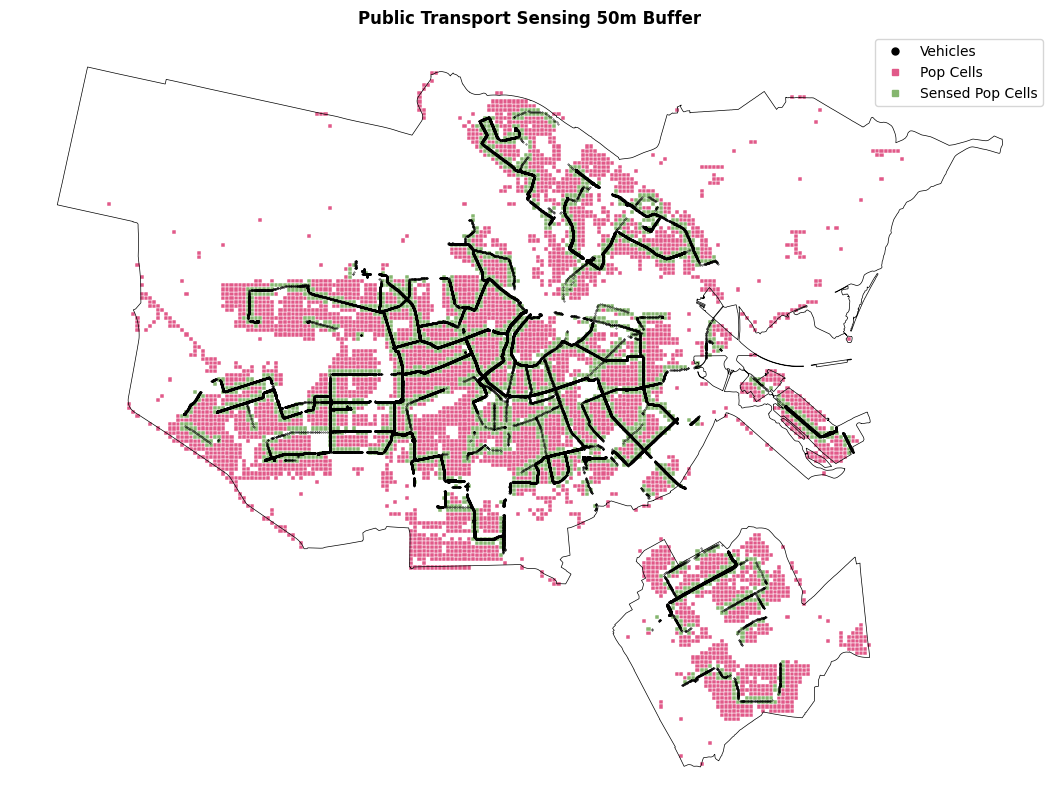

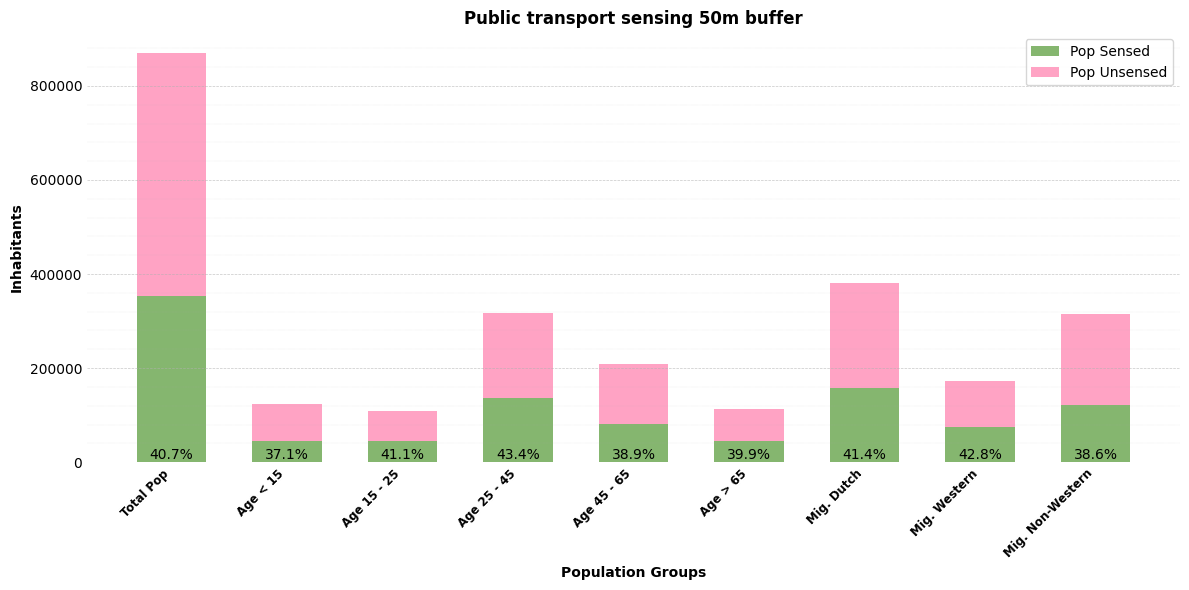

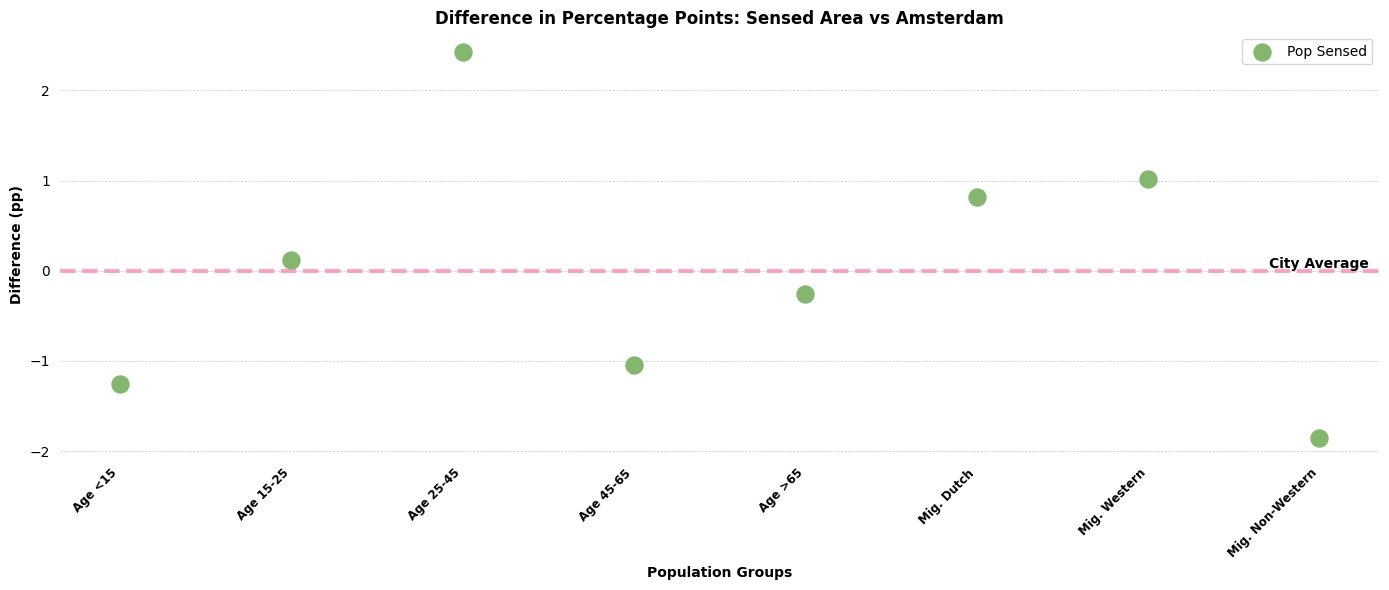

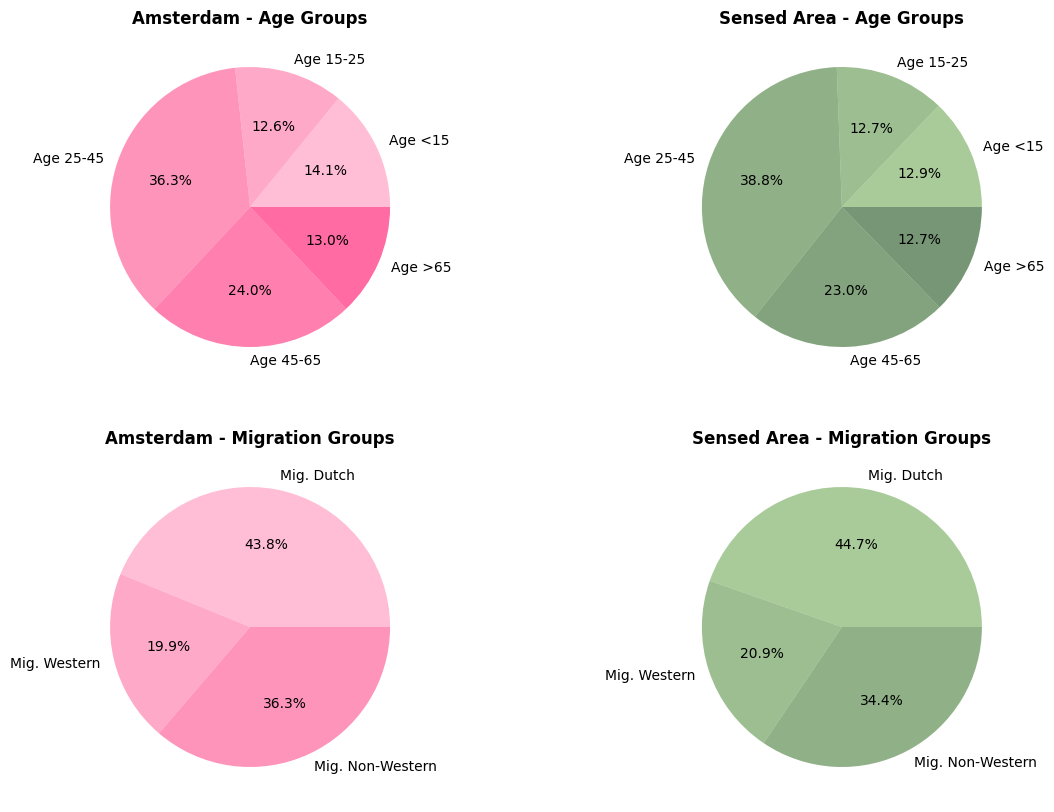

In [ ]:
# call analysis
sums_df, cbs_gdf, joined_gdf, average_stats = master_function_analysis(
    gpd_vehicles, cbs_filepath, buffer_distance)
# call visualization
fig1, fig2, fig3, fig4 = visualization_master_function(
    gpd_vehicles, cbs_gdf, joined_gdf, ams_gdf, buffer_distance, sums_df, average_stats)